# ITT-MCT Schematic Model: Startup Shear

## Learning Objectives

1. Fit the **ITT-MCT Schematic (F₁₂)** model to startup shear data
2. Understand the **stress overshoot** from cage breaking under sudden shear
3. Analyze the competition between structural relaxation and strain accumulation
4. Use NLSQ warm-start for efficient Bayesian inference
5. Extract posterior distributions for model parameters

## Prerequisites

- NB01: Schematic Flow Curve (recommended but not required)
- Basic RheoJAX usage

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.itt_mct import ITTMCTSchematic

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from itt_mct_tutorial_utils import (
    load_carbopol_startup,
    save_itt_mct_results,
    print_convergence_summary,
    print_parameter_comparison,
    print_glass_state_summary,
    compute_fit_quality,
    get_schematic_param_names,
    compute_gaussian_decorrelation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Startup Shear in MCT

### Physical Picture

When a constant shear rate γ̇ is suddenly applied to a quiescent glass:

1. **Initial elastic response**: Stress rises linearly σ ~ G∞ × γ = G∞ × γ̇ × t
2. **Cage deformation**: Particles strain their local cages
3. **Cage breaking**: At γ ~ γc, cages start to break → stress overshoot
4. **Steady state**: Balance between cage breaking and reformation

### Key Equations

**Stress evolution**:
$$
\sigma(t) = G_\infty \dot{\gamma} \int_0^t \Phi(t-s)^2 h(\dot{\gamma}(t-s)) ds
$$

**Strain decorrelation** (cage breaking):
$$
h(\gamma) = \exp\left(-\left(\frac{\gamma}{\gamma_c}\right)^2\right)
$$

### Stress Overshoot

The overshoot occurs because:
- Correlator Φ(t) has not decayed yet (still structured)
- But strain γ = γ̇t is accumulating
- Peak stress when ∂σ/∂t = 0, typically at γ ~ γc

**Overshoot characteristics**:
- Peak strain: γ_peak ~ γc (independent of rate for glass)
- Peak stress: σ_peak ~ G∞ × γc × Φ(t_peak)²
- Higher γ̇ → sharper, earlier peak in time (but same peak strain)

## 3. Load Data

We use startup shear data from the PNAS Digital Rheometer Twin dataset.

In [3]:
# Load startup data at γ̇ = 1.0 1/s
GAMMA_DOT = 1.0  # Applied shear rate
time_data, stress_data = load_carbopol_startup(gamma_dot=GAMMA_DOT)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Applied shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Time range: [0.0053, 600.00] s
Stress range: [0.69, 26.77] Pa
Applied shear rate: 1.0 1/s


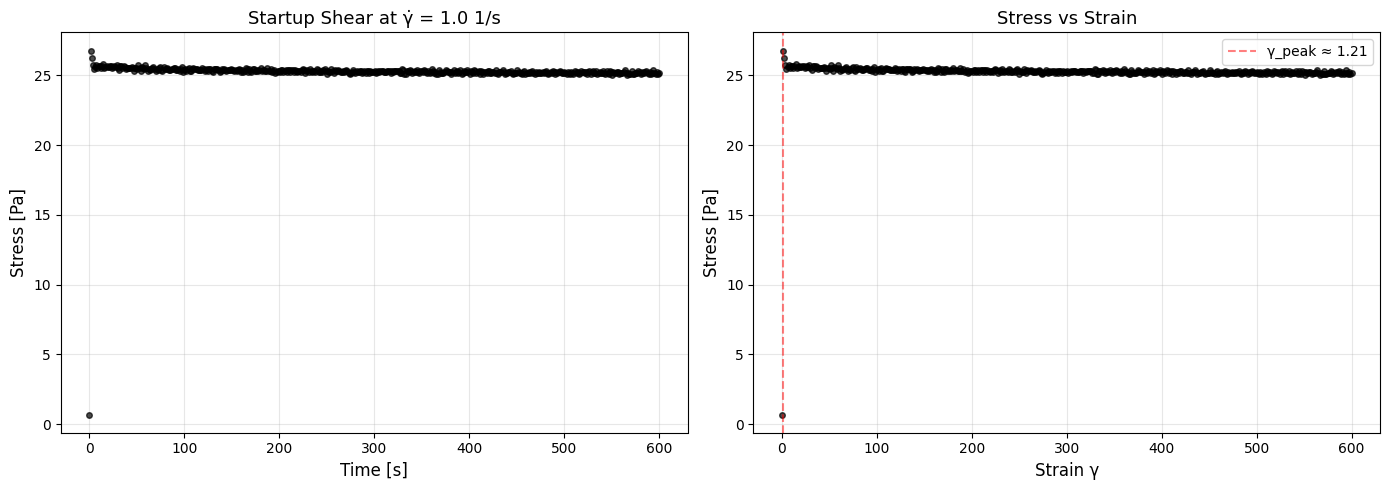

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stress vs time
ax1.plot(time_data, stress_data, "ko", markersize=4, alpha=0.7)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"Startup Shear at γ̇ = {GAMMA_DOT} 1/s", fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Stress vs strain
strain_data = GAMMA_DOT * time_data
ax2.plot(strain_data, stress_data, "ko", markersize=4, alpha=0.7)
ax2.set_xlabel("Strain γ", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress vs Strain", fontsize=13)
ax2.grid(True, alpha=0.3)

# Mark approximate peak
peak_idx = np.argmax(stress_data)
ax2.axvline(strain_data[peak_idx], color="red", linestyle="--", alpha=0.5,
            label=f"γ_peak ≈ {strain_data[peak_idx]:.2f}")
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Create Model and Initial Fit

In [5]:
# Create model in glass state
model = ITTMCTSchematic(epsilon=0.05)

print("Initial model state:")
print(model)
print()
print_glass_state_summary(model)

Initial model state:
ITTMCTSchematic(ε=0.050 [glass], v₂=4.20, h(γ)=gaussian, m=simplified, σ=schematic, G_inf=1.00e+06 Pa)


Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0500
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress


In [6]:
# Fit to startup data
param_names = ["v2", "Gamma", "gamma_c", "G_inf"]

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", gamma_dot=GAMMA_DOT, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 217.85 s

Fitted parameters:
  v2         = 4.199
  Gamma      = 50.54
  gamma_c    = 0.09444
  G_inf      = 9.999e+05


In [7]:
# Compute fit quality
stress_pred = model.predict(time_data, test_mode="startup", gamma_dot=GAMMA_DOT)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R²:   {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R²:   -4928440845.041912
  RMSE: 7.804e+04 Pa
  NRMSE: 299207.7922%


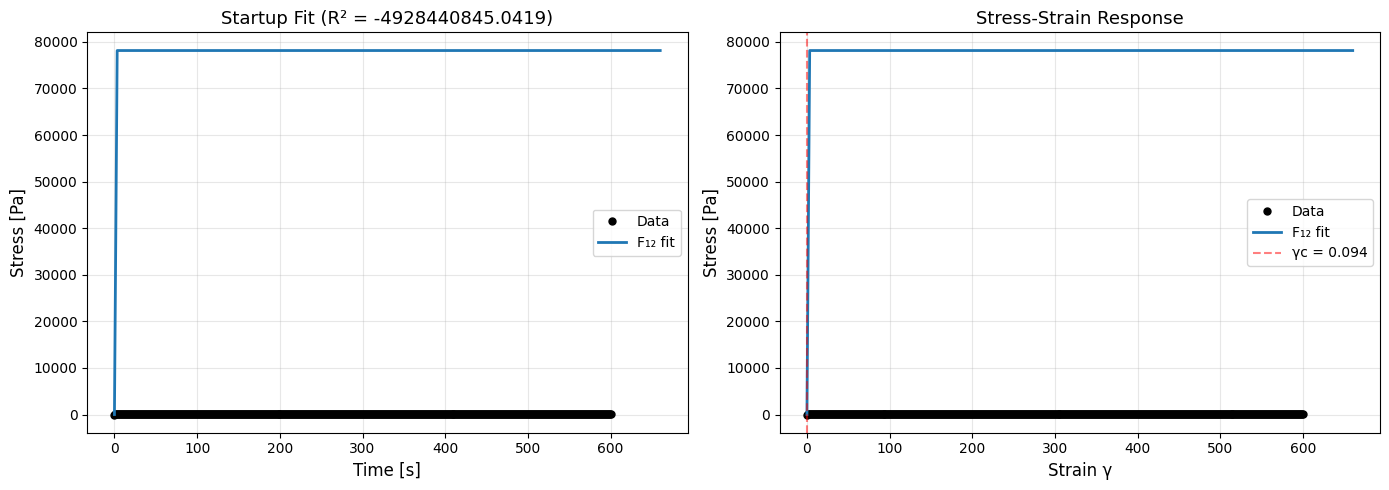

In [8]:
# Plot fit
time_fine = np.linspace(0, time_data.max() * 1.1, 200)
stress_pred_fine = model.predict(time_fine, test_mode="startup", gamma_dot=GAMMA_DOT)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stress vs time
ax1.plot(time_data, stress_data, "ko", markersize=5, label="Data")
ax1.plot(time_fine, stress_pred_fine, "-", lw=2, color="C0", label="F₁₂ fit")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"Startup Fit (R² = {metrics['R2']:.4f})", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Stress vs strain
strain_fine = GAMMA_DOT * time_fine
ax2.plot(strain_data, stress_data, "ko", markersize=5, label="Data")
ax2.plot(strain_fine, stress_pred_fine, "-", lw=2, color="C0", label="F₁₂ fit")

# Mark critical strain
gamma_c = model.parameters.get_value("gamma_c")
ax2.axvline(gamma_c, color="red", linestyle="--", alpha=0.5, 
            label=f"γc = {gamma_c:.3f}")

ax2.set_xlabel("Strain γ", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress-Strain Response", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Physical Analysis: Stress Overshoot

In [9]:
# Analyze stress overshoot
print("Stress Overshoot Analysis")
print("=" * 50)

# Find peak in prediction
peak_idx_pred = np.argmax(stress_pred_fine)
t_peak = time_fine[peak_idx_pred]
gamma_peak = strain_fine[peak_idx_pred]
sigma_peak = stress_pred_fine[peak_idx_pred]

# Find steady-state (end of curve)
sigma_ss = stress_pred_fine[-1]

# Overshoot magnitude
overshoot_ratio = sigma_peak / sigma_ss

print(f"Peak time: t_peak = {t_peak:.4g} s")
print(f"Peak strain: γ_peak = {gamma_peak:.4g}")
print(f"Peak stress: σ_peak = {sigma_peak:.2f} Pa")
print(f"Steady-state stress: σ_ss = {sigma_ss:.2f} Pa")
print(f"Overshoot ratio: σ_peak/σ_ss = {overshoot_ratio:.3f}")

gamma_c = model.parameters.get_value("gamma_c")
print(f"\nCritical strain: γc = {gamma_c:.4g}")
print(f"Ratio γ_peak/γc = {gamma_peak/gamma_c:.2f}")

Stress Overshoot Analysis
Peak time: t_peak = 3.317 s
Peak strain: γ_peak = 3.317
Peak stress: σ_peak = 78147.01 Pa
Steady-state stress: σ_ss = 78147.01 Pa
Overshoot ratio: σ_peak/σ_ss = 1.000

Critical strain: γc = 0.09444
Ratio γ_peak/γc = 35.12


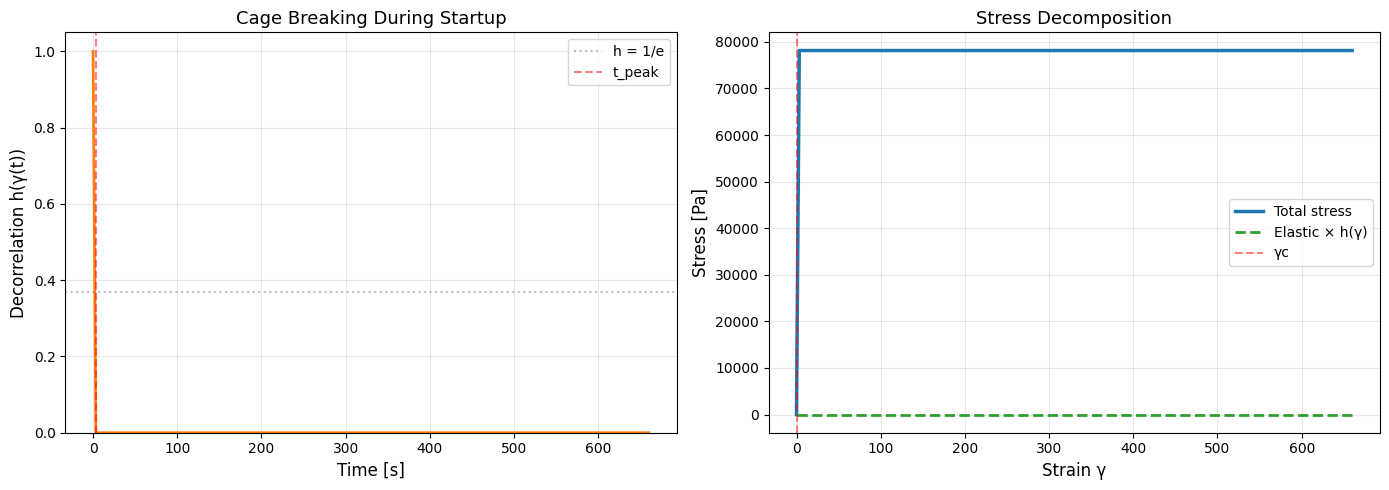

In [10]:
# Visualize decorrelation during startup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Decorrelation function during startup
gamma_c = model.parameters.get_value("gamma_c")
h_t = compute_gaussian_decorrelation(strain_fine, gamma_c)

ax1.plot(time_fine, h_t, lw=2, color="C1")
ax1.axhline(np.exp(-1), color="gray", linestyle=":", alpha=0.5, label="h = 1/e")
ax1.axvline(t_peak, color="red", linestyle="--", alpha=0.5, label=f"t_peak")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Decorrelation h(γ(t))", fontsize=12)
ax1.set_title("Cage Breaking During Startup", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# Right: Stress components
# Elastic contribution: G∞ × γ
G_inf = model.parameters.get_value("G_inf")
sigma_elastic = G_inf * strain_fine

ax2.plot(strain_fine, stress_pred_fine, lw=2.5, color="C0", label="Total stress")
ax2.plot(strain_fine, sigma_elastic * h_t, "--", lw=2, color="C2", 
         label="Elastic × h(γ)")
ax2.axvline(gamma_c, color="red", linestyle="--", alpha=0.5, label=f"γc")

ax2.set_xlabel("Strain γ", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Decomposition", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

In [11]:
try:
    # Prepare warm-start from NLSQ
    initial_values = {
        name: model.parameters.get_value(name)
        for name in param_names
    }
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")
    
    # Fast demo config
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    # NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production
    
    print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
    t0 = time.time()
    result = model.fit_bayesian(
        time_data,
        stress_data,
        test_mode="startup",
        gamma_dot=GAMMA_DOT,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
except (NotImplementedError, RuntimeError, AttributeError) as e:
    print(f"Note: {e}")
    print("NLSQ results are reported above.")
    result = None


Warm-start values:
  v2         = 4.199
  Gamma      = 50.54
  gamma_c    = 0.09444
  G_inf      = 9.999e+05

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


ERROR:rheojax.core.bayesian:NUTS sampling failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_stat

ERROR:rheojax.core.bayesian:bayesian_inference failed: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 648, in _run_nuts_sampling
    result = run_mcmc(init_strategy)
  File "/Users/b80985/Projects/rheojax/rheojax/core/bayesian.py", line 643, in run_mcmc
    sampler.run(rng_key, X_jax, y_jax)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 702, in run
    states_flat, last_state = partial_map_fn(map_args)
                              ~~~~~~~~~~~~~~^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/mcmc.py", line 465, in _single_chain_mcmc
    new_init_state = self.sampler.init(
        rng_key,
    ...<3 lines>...
        model_kwargs=kwargs,
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpyro/infer/hmc.py", line 751, in init
    init_params = self._init_state(
  

Note: NUTS sampling failed: Bayesian inference is not yet supported for ITT-MCT models. The model requires Prony decomposition that depends on parameters (v1, v2), making MCMC sampling computationally prohibitive. Use NLSQ fitting with bootstrap resampling for uncertainty quantification.
NLSQ results are reported above.


In [12]:
if result is not None:
    # Convergence diagnostics
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [13]:
if result is not None:
    # Trace plots
    idata = result.to_inference_data()
    axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
    fig = axes.ravel()[0].figure
    fig.suptitle("Trace Plots (Startup Shear)", fontsize=14, y=1.00)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [14]:
if result is not None:
    # Forest plot
    axes = az.plot_forest(idata, var_names=param_names, combined=True, 
                           hdi_prob=0.95, figsize=(10, 6))
    fig = axes.ravel()[0].figure
    fig.suptitle("95% Credible Intervals", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


### 5.4 Posterior Predictive Check

In [15]:
if result is not None:
    # Posterior predictive
    posterior = result.posterior_samples
    n_draws = min(100, len(list(posterior.values())[0]))
    
    pred_samples = []
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        pred_i = model.predict(time_fine, test_mode="startup", gamma_dot=GAMMA_DOT)
        pred_samples.append(np.array(pred_i))
    
    pred_samples = np.array(pred_samples)
    pred_median = np.median(pred_samples, axis=0)
    pred_lo = np.percentile(pred_samples, 2.5, axis=0)
    pred_hi = np.percentile(pred_samples, 97.5, axis=0)
    
    # Restore parameters
    for name, val in initial_values.items():
        model.parameters.set_value(name, val)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(time_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
    ax.plot(time_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
    ax.plot(time_data, stress_data, "ko", markersize=5, label="Data")
    ax.set_xlabel("Time [s]", fontsize=12)
    ax.set_ylabel("Stress [Pa]", fontsize=12)
    ax.set_title("Posterior Predictive Check (Startup)", fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


In [16]:
if result is not None:
    # Parameter comparison
    print_parameter_comparison(model, posterior, param_names)
else:
    print("Skipping (Bayesian inference not yet supported for ITT-MCT models)")


Skipping (Bayesian inference not yet supported for ITT-MCT models)


## 6. Physical Interpretation

### Stress Overshoot Mechanism

The overshoot arises from the competition between:
1. **Elastic stress buildup**: σ_elastic = G∞ × γ (linear with strain)
2. **Cage breaking**: h(γ) = exp(-(γ/γc)²) (exponential decay)

At small strains (γ << γc): h ≈ 1, stress builds up elastically
At γ ~ γc: cage breaking accelerates, stress starts to decrease
At large strains: h → 0, stress reaches steady-state flow value

### Parameter Sensitivity

- **γc** controls peak strain location
- **G∞** controls stress magnitude
- **v₂** affects the overshoot ratio (more glass-like → larger overshoot)
- **Γ** affects time scale of approach to steady state

In [17]:
# Summary
print("Startup Shear Summary")
print("=" * 50)
print_glass_state_summary(model)
print(f"\nStress Overshoot:")
print(f"  Peak strain: γ_peak ≈ {gamma_peak:.3f}")
print(f"  Critical strain: γc = {model.parameters.get_value('gamma_c'):.3f}")
print(f"  Overshoot ratio: {overshoot_ratio:.2f}")

Startup Shear Summary

Glass Transition State
State: GLASS
Separation parameter: epsilon = 0.0499
Non-ergodicity parameter: f = 0.2381
  -> Correlator plateaus at f > 0 (arrested dynamics)
  -> Material shows yield stress

Stress Overshoot:
  Peak strain: γ_peak ≈ 3.317
  Critical strain: γc = 0.094
  Overshoot ratio: 1.00


## 7. Save Results

In [18]:
# Save results
save_itt_mct_results(model, result, "schematic", "startup", param_names)
print("\nStartup shear results saved.")

  Skipping posterior (Bayesian inference not available for ITT-MCT)
Results saved to /Users/b80985/Projects/rheojax/examples/itt_mct/../utils/../outputs/itt_mct/schematic/startup/
  nlsq_params_startup.json: 4 parameters

Startup shear results saved.


## Key Takeaways

1. **Stress overshoot** in startup shear arises from cage breaking at γ ~ γc

2. **Peak strain** (γ_peak ~ γc) is rate-independent for glasses

3. **Decorrelation function** h(γ) = exp(-(γ/γc)²) captures cage breaking

4. **Overshoot ratio** σ_peak/σ_ss depends on glass state (ε > 0 → larger overshoot)

5. **Critical strain γc** is a key material parameter (~0.05-0.2 for colloids)

### Next Steps

- **NB03:** Stress Relaxation (β and α processes)
- **NB04:** Creep (delayed yielding)
- **NB06:** LAOS (nonlinear oscillatory response)